# Feature Selection and Engineering

##### *In which we boost, combine, split, or otherwise manipulate the features of crabs.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/2-features)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/2-features/features.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


## Introduction

Crabs are complex creatures. Let's engineer some features to help our model find the best crabs for harvest.

We'll need to use domain knowledge to extract more features from our dataset's column.

![This kills the crab.](https://i.kym-cdn.com/photos/images/newsfeed/000/112/843/killcrab.jpg)

For example, we can find the edible weight of the crab by subtracting the viscera weight from the shucked weight.

However, we need to be careful not to overfit the model by adding collinear features.


### Define Constants


In [1]:
%%time
CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_CACHE_FILE = '../cache/designrcrabs.feather'
NEXT_NOTEBOOK = '../3-evaluation/evaluation.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/designr_model.weights.h5'
MODEL_DOT_FILE = '../cache/dot_diagram.png'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2
NUM_HIDDEN_LAYERS = 1
NUM_UNITS = 8


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries


In [2]:
%%time
from notebooks.time_for_crab.mlutils import display_df, generate_neural_network, generate_neural_pyramid
from notebooks.time_for_crab.mlutils import plot_training_loss, plot_training_loss_from_dict, plot_true_vs_pred_from_dict
from notebooks.time_for_crab.mlutils import score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

from typing import Generator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 641 ms
Wall time: 3.35 s


### Load Data from Cache

In the [model selection section](../1-models/models.ipynb), we grabbed the data from the cache. Let's load it back up.


In [3]:
%%time
crabs = pd.read_feather(CACHE_FILE)
crabs_test = pd.read_feather(CACHE_FILE.replace('.feather', '_test.feather'))

display_df(crabs, show_distinct=True)

# split features from target
X_train = crabs.drop([PREDICTION_TARGET], axis=1)
y_train = crabs[PREDICTION_TARGET]

X_test = crabs_test.drop([PREDICTION_TARGET], axis=1)
y_test = crabs_test[PREDICTION_TARGET]

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')


DataFrame shape: (3031, 11)
First 5 rows:
        Length  Diameter    Height    Weight  Shucked Weight  Viscera Weight  \
3483  1.724609  1.312500  0.500000  50.53125       25.984375        9.429688   
993   1.612305  1.312500  0.500000  41.09375       17.031250        7.273438   
1427  1.650391  1.262695  0.475098  40.78125       19.203125        8.078125   
3829  1.362305  1.150391  0.399902  25.43750        9.664062        4.691406   
1468  1.250000  0.924805  0.375000  30.09375       14.007812        6.320312   

      Shell Weight  Sex_F  Sex_I  Sex_M  Age  
3483     13.070312  False  False   True   12  
993      14.320312   True  False  False   13  
1427      5.046875  False  False   True   11  
3829      9.781250  False  False   True   10  
1468      8.390625  False  False   True    9  
<class 'pandas.core.frame.DataFrame'>
Index: 3031 entries, 3483 to 658
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 

## Rebuild our Model

### Neural Network Architecture

We'll use a simple feedforward neural network with one hidden layer.

- **Input Layer**
    - All features, for now.
- **Normalizer Layer**
    - Adapted to all features in the training data. 
- **Hidden Layers**
    - One dense layer with 8 units and ReLU activation.
- **Output Layer**
    - Layer with one output, the predicted age.


In [4]:
%%time
# initialize the all_models dictionary and add the full feature model
all_models = {
    'full_feature':
        generate_neural_network(
            X_train,
            num_hidden_layers=NUM_HIDDEN_LAYERS,
            num_units=NUM_UNITS)}

all_models['full_feature'].summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118 (476.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 53.1 ms


### Configure the Neural Network Model

- **Optimizer**
    - Nadam: Adaptive Moment Estimation with Nesterov Accelerated Gradient
        - Combines Adam and Nesterov momentum.
        - Adam is a popular optimizer for its speed and performance.
        - Nesterov momentum helps the optimizer converge faster.
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint
    - Learning Rate Scheduler
        - Start = 0.01 (best from static tuning)
        - Factor = 0.75 (reduce learning rate by 25%)
        - Patience = 9 epochs (wait 9 epochs of non-improvement before reducing learning rate)

##### Define Common Configurations


In [5]:
%%time

def common_compile_options(
        optimizer:keras.Optimizer=None,
        loss_metric:str='mean_squared_error'):
    """Return a dictionary of common compile options.

    :param optimizer: The optimizer to use. Defaults to Adam with LR=0.001.
    :param loss_metric: The loss metric to use. Defaults to 'mean_squared_error'.
    """
    return {
        'optimizer': optimizer if optimizer is not None else keras.optimizers.Nadam(learning_rate=0.01),
        'loss': loss_metric
    }


# define common callbacks
common_learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75,
    patience=9,
    verbose=1)

common_checkpoint_options = {
    'monitor': 'val_loss',
    'save_best_only': True,
    'save_weights_only': True,
    'mode': 'min'
}

all_models['full_feature'].compile(**common_compile_options())

full_feature_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.weights.h5', '_full_feature.weights.h5'),
    **common_checkpoint_options)


CPU times: total: 15.6 ms
Wall time: 5.51 ms


### Train the Model with Full Features



Epoch 58: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 87: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.
CPU times: total: 2.02 s
Wall time: 7.98 s


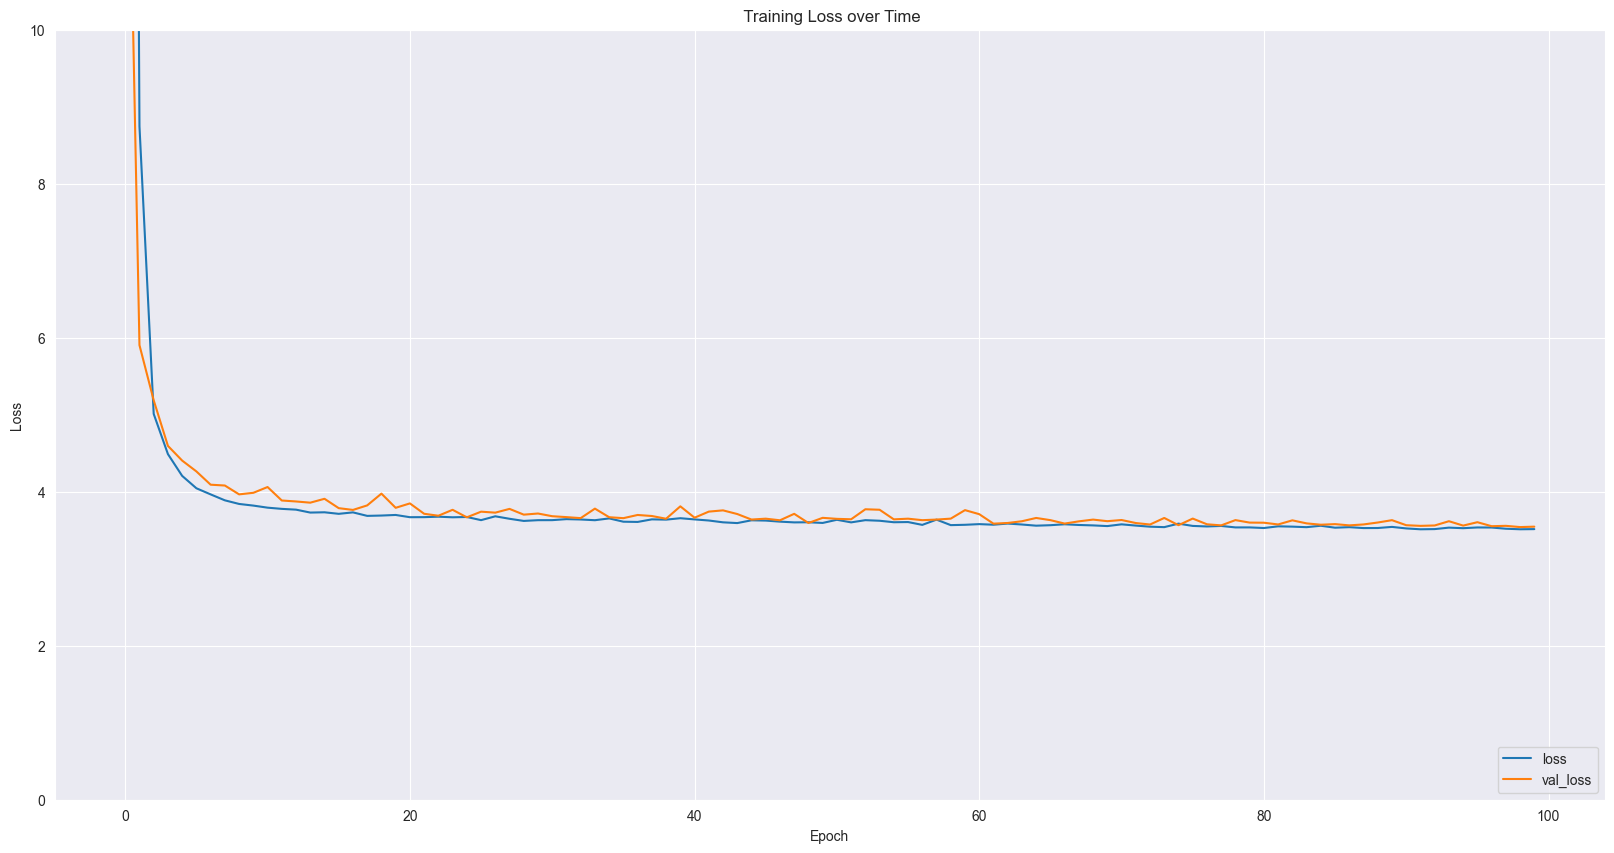

In [6]:
%%time
common_fit_options = {
    'x': X_train,
    'y': y_train,
    'epochs': NUM_EPOCHS,
    'verbose': 0,
    'validation_split': VALIDATION_SPLIT
}

# train the model
all_histories = {'full_feature':
    all_models['full_feature'].fit(
        **common_fit_options,
        callbacks=[common_learning_rate_scheduler, full_feature_checkpoint])}

# plot the training loss
plot_training_loss(all_histories['full_feature'])


### Score the Model with Full Features


In [7]:
%%time
full_feature_preds = all_models['full_feature'].predict(X_test).flatten()
full_feature_scores_df = score_model(full_feature_preds, np.array(y_test), index='full_feature')
# Add it to the leaderboard
leaderboard_df = score_combine(pd.DataFrame(), full_feature_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 0 ns
Wall time: 103 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
full_feature,3.800121,1.434196,0.229652,0.228794


## Feature Analysis

### Distributions of Features

If you recall from [exploratory data analysis](../0-exploratory/exploratory.ipynb), the features are normalized using the training data's ranges as part of the model's architecture.

Let's take another look at the original distributions of the features.


CPU times: total: 172 ms
Wall time: 294 ms


Text(0.5, 1.0, 'Feature Distributions')

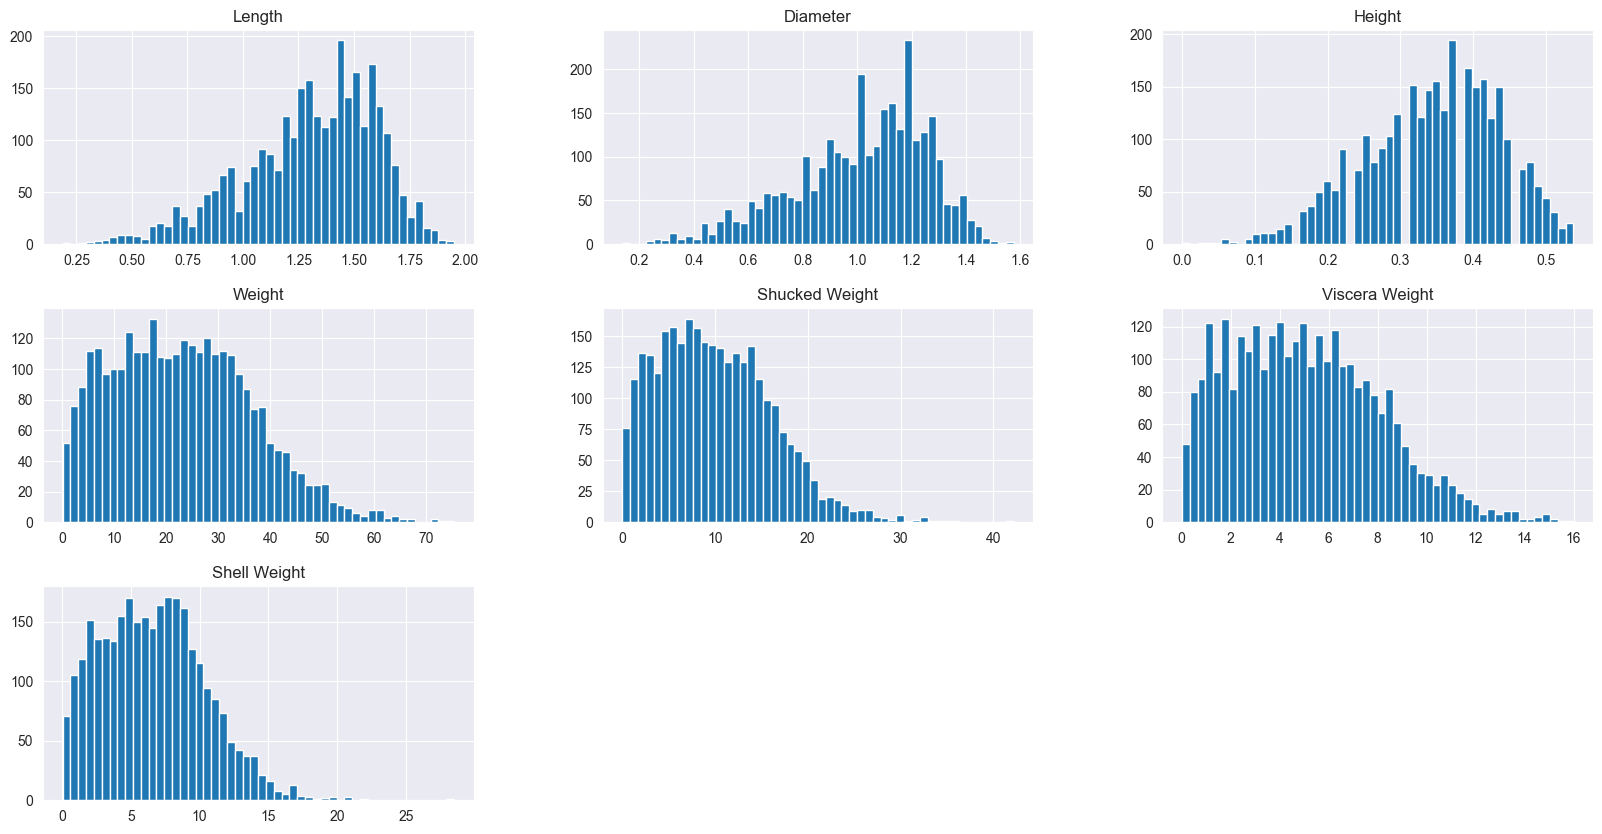

In [8]:
%%time
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)
plt.title('Feature Distributions')


### Correlation Matrix

To see how the features are correlated with the target label, we'll plot a heatmap of the correlation matrix.


CPU times: total: 62.5 ms
Wall time: 90.2 ms


<Axes: title={'center': 'Correlation Graph'}>

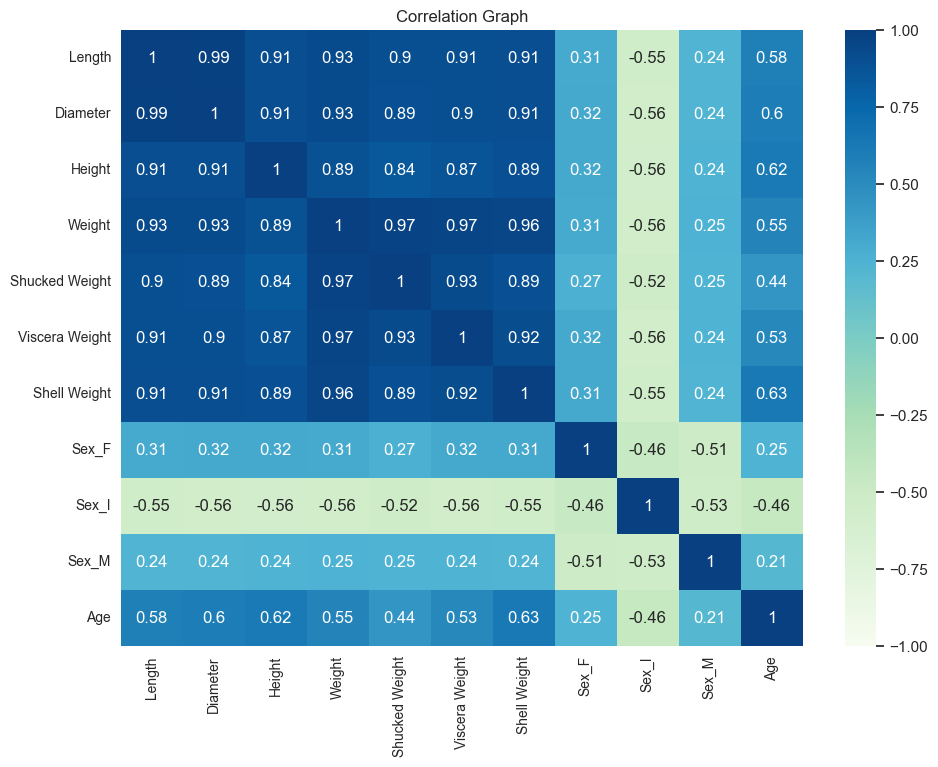

In [9]:
%%time
plt.figure(figsize = (11,8))
plt.title('Correlation Graph')
# Plotting the heatmap to check the correlation between the Target Label and other features
sns.set()
sns.heatmap(crabs.corr(), vmin=-1, vmax=1, annot=True, cmap='GnBu')


#### Correlation Observations

- `Sex_I` is negatively correlated with `Age`.
    - This makes sense since it's more difficult to determine the sex of younger crabs.
- `Length` and `Diameter` are highly correlated.
    - This makes sense since they are both measurements of the same thing.
- Many of the different weight measurements are correlated.
    - Multicollinearity might be an issue here.
- Most size features excluding `Shucked Weight` have similar correlations with `Age`.
    - `Shucked Weight` might not be a good feature, since this kills the crab.


## Feature Selection

Select only the most important features. We'll use **Recursive Feature Elimination** (RFE).

In practice, we would want to remove features which, when measured, kill the crab (e.g. `Shucked Weight`).

### Recursive Feature Elimination (RFE)

1. Train a model for each feature ($n$ features).
2. Plot the validation loss for each model.
3. Rank the features by importance (lowest loss -> most importance).
4. Train a model with the top $n-k$ features.
   1. Gradually increase $k$ until the model's performance degrades significantly.


In [10]:
%%time
# implement RFE from scratch

# train a model for each feature
for feature in X_train.columns:
    # create a model with only the current feature
    layer_feature_normalizer = keras.layers.Normalization(axis=None)
    # normalize the feature
    layer_feature_normalizer.adapt(np.array(X_train[feature]))
    # build the model
    all_models[feature] = keras.Sequential([
        keras.layers.Input(shape=(1,)),     # input layer
        layer_feature_normalizer,           # normalizer
        *generate_neural_pyramid(NUM_HIDDEN_LAYERS, NUM_UNITS),
        keras.layers.Dense(units=1)         # output layer
    ])
    # compile the model
    all_models[feature].compile(**common_compile_options())
    # checkpoint
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        MODEL_CHECKPOINT_FILE.replace('.weights.h5', f'_{feature}.weights.h5'),
        **common_checkpoint_options)
    # fit options
    model_fit_options = {k: v for k, v in common_fit_options.items() if k != 'x'}
    model_fit_options['x'] = X_train[feature]
    # train the model
    all_histories[feature] = \
        all_models[feature].fit(
            **model_fit_options,
            callbacks=[common_learning_rate_scheduler, model_checkpoint])



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 59: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0017797850305214524.

Epoch 95: ReduceLROnPlateau reducing learning rate to 0.0013348387728910893.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 40: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.001779785030521

C:\Users\ahest\dev\.venv-ai\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)



Epoch 51: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.


C:\Users\ahest\dev\.venv-ai\Lib\site-packages\numpy\core\_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)



Epoch 53: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.

Epoch 98: ReduceLROnPlateau reducing learning rate to 0.0017797850305214524.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.

Epoch 55: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0017797850305214524.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.001334838772891

#### Plot the Validation Loss for Each Feature


CPU times: total: 46.9 ms
Wall time: 74.3 ms


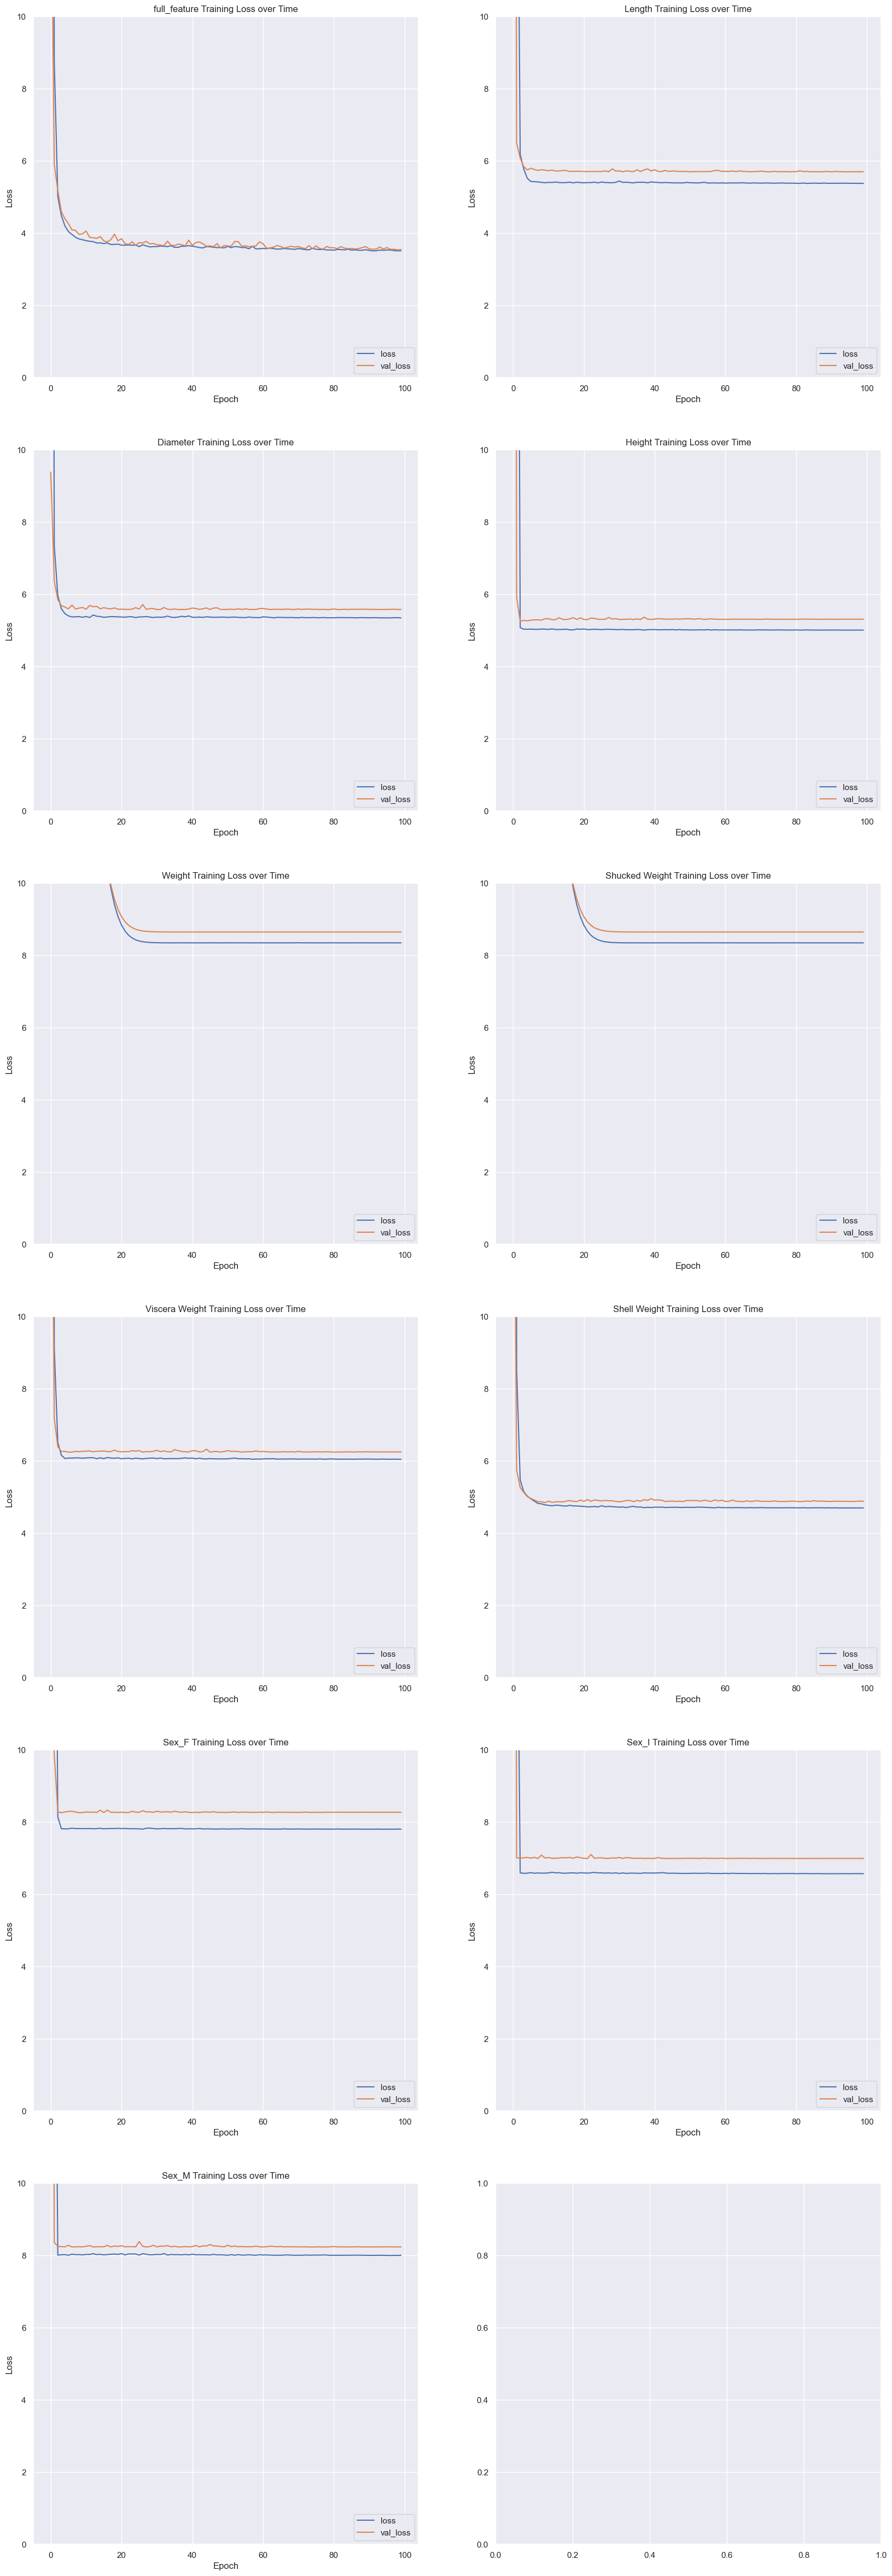

In [11]:
%%time
plot_training_loss_from_dict(all_histories)


#### Score the Models for Each Feature

In [12]:
%%time
for feature in X_train.columns:
    feature_preds = all_models[feature].predict(X_test[feature]).flatten()
    feature_scores_df = score_model(feature_preds, np.array(y_test), index=feature)
    # Add it to the leaderboard
    leaderboard_df = score_combine(leaderboard_df, feature_scores_df)
    
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 375 ms
Wall time: 867 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
full_feature,3.800121,1.434196,2.296518e-01,2.287943e-01
Length,5.456762,1.750866,-7.612283e-01,-7.650436e-01
Diameter,5.349194,1.732865,-7.325021e-01,-7.328969e-01
Height,5.059891,1.708877,-4.743708e-01,-4.748745e-01
Weight,7.989068,2.165864,-8.781164e+12,-8.784072e+12
Shucked Weight,7.989678,2.165916,-8.781164e+12,-8.784744e+12
Viscera Weight,5.957139,1.846886,-1.459981e+00,-1.460978e+00
Shell Weight,4.810484,1.658184,-3.358524e-01,-3.361012e-01
Sex_F,7.296921,2.065566,-1.226833e+01,-1.227008e+01
Sex_I,6.429297,1.896815,-2.639576e+00,-2.640048e+00


#### Bar Chart of Feature Importance

CPU times: total: 0 ns
Wall time: 18.9 ms


(1.2, 2.3)

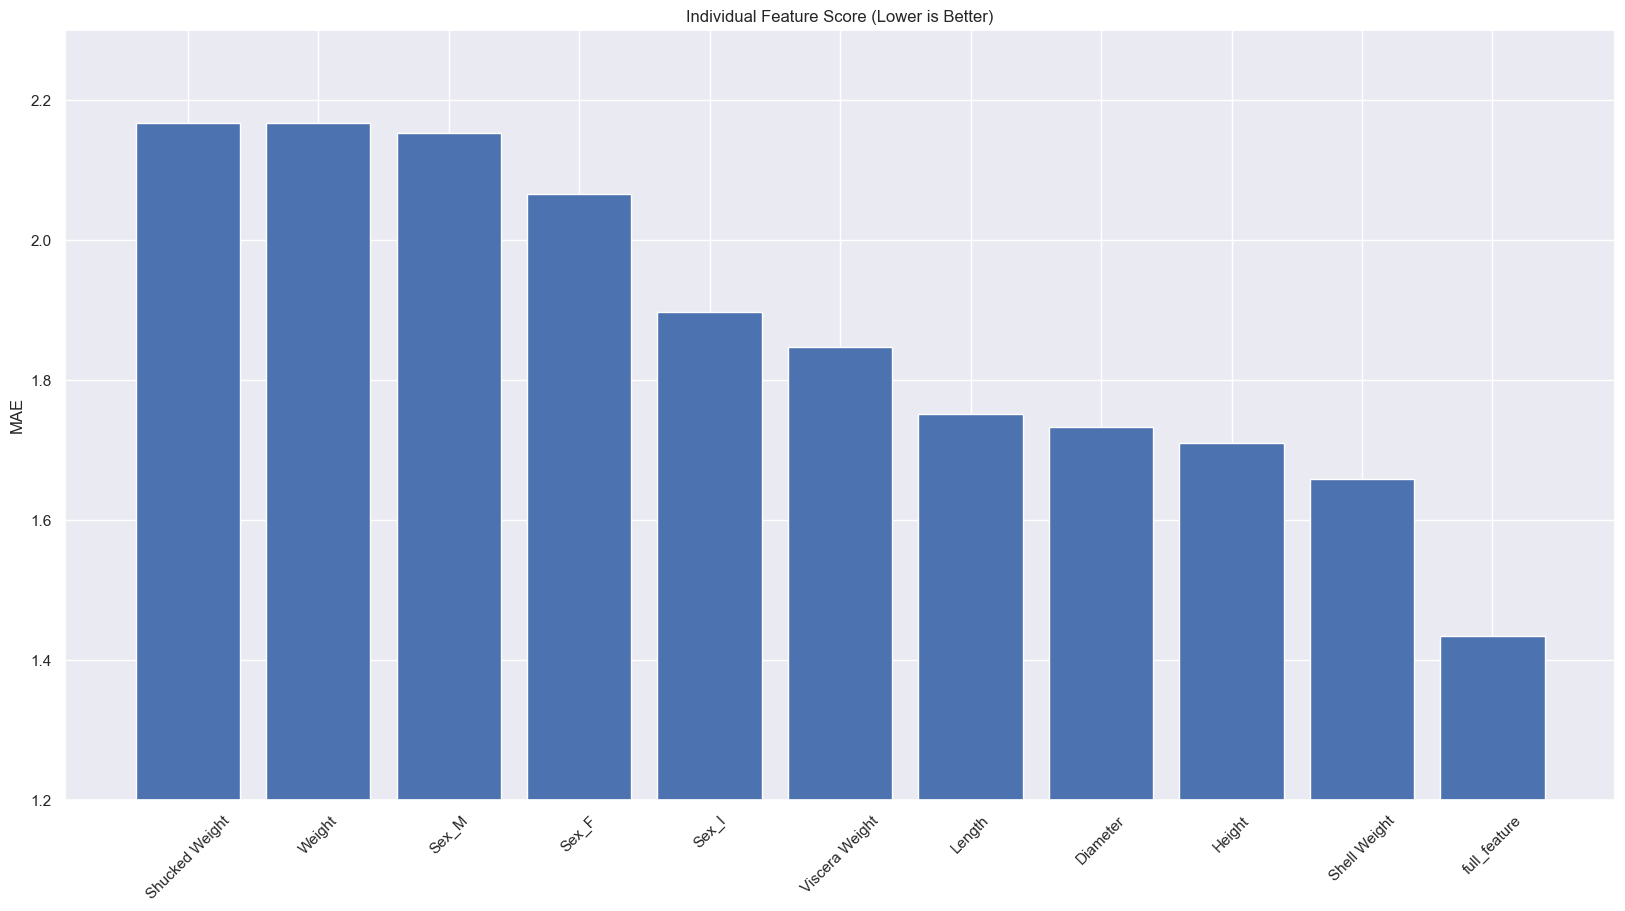

In [13]:
%%time
# sort the leaderboard by mean absolute error
sorted_leaderboard_df = leaderboard_df.sort_values(by='mean_absolute_error', ascending=False)
plt.figure(figsize=(20, 10))
plt.title('Individual Feature Score (Lower is Better)')
plt.bar(sorted_leaderboard_df.index, sorted_leaderboard_df['mean_absolute_error'])
plt.xticks(rotation=45)
plt.ylabel('MAE')
plt.ylim(1.2, 2.3)


#### Feature Importance Observations

- `Shucked Weight` is the worst feature.
    - This kills the crab.
        - We should remove it first.
- Surprisingly, `Weight` is not as important as the other size features.
    - This might be due to multicollinearity.
        - Let's remove it as well.
- `Shell Weight` is the most important feature.
    - Older crabs must have thicker shells.


### Eliminate the Worst Features

Next, we'll gradually remove the worst features from the full-featured model and retrain.

Each step, the model will be trained with one less feature until we run out of features.


In [14]:
%%time
# implement RFE from scratch
X_train_rfe = X_train.copy()
X_test_rfe = X_test.copy()
rfe_histories = {'full_feature': all_histories['full_feature']}
rfe_leaderboard_df = leaderboard_df.loc[['full_feature']]
# starting with the worst feature, gradually cut features and retrain
for feature in sorted_leaderboard_df.index:
    if feature == 'full_feature':
        # don't remove 'full_feature' as it's an aggregate
        continue
    # drop the next worst feature
    X_train_rfe = X_train_rfe.drop([feature], axis=1)
    X_test_rfe = X_test_rfe.drop([feature], axis=1)
    print(f'Removed feature: {feature}')
    print(f'X_train_rfe shape: {X_train_rfe.shape}')
    if X_train_rfe.shape[1] == 0:
        # no more features to remove
        break
    # create a new model with the reduced feature set
    # model_name = f'{"_".join([col[:min(5, len(col))] for col in X_train_rfe.columns])}'
    model_name = f'Without_{feature}'
    all_models[model_name] = \
        generate_neural_network(X_train_rfe, num_hidden_layers=NUM_HIDDEN_LAYERS, num_units=NUM_UNITS)
    # compile the model
    all_models[model_name].compile(**common_compile_options())
    # checkpoint
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        MODEL_CHECKPOINT_FILE.replace('.weights.h5', f'_{model_name}.weights.h5'),
        **common_checkpoint_options)
    # fit options
    model_fit_options = {k: v for k, v in common_fit_options.items() if k != 'x'}
    model_fit_options['x'] = X_train_rfe
    # train the model
    rfe_histories[model_name] = \
        all_models[model_name].fit(
            **model_fit_options,
            callbacks=[common_learning_rate_scheduler, model_checkpoint])
    # score the model
    preds = all_models[model_name].predict(X_test_rfe).flatten()
    scores_df = score_model(preds, np.array(y_test), index=model_name)
    # add it to the leaderboard
    rfe_leaderboard_df = score_combine(rfe_leaderboard_df, scores_df)


Removed feature: Shucked Weight
X_train_rfe shape: (3031, 9)

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Removed feature: Weight
X_train_rfe shape: (3031, 8)

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.005624999874271452.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Removed feature: Sex_M
X_train_rfe shape: (3031, 7)

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.

Epoch 56: ReduceLROnPlateau reducing learning rate to 0.0056

#### Plot the Validation Loss for Each Model


CPU times: total: 46.9 ms
Wall time: 67.8 ms


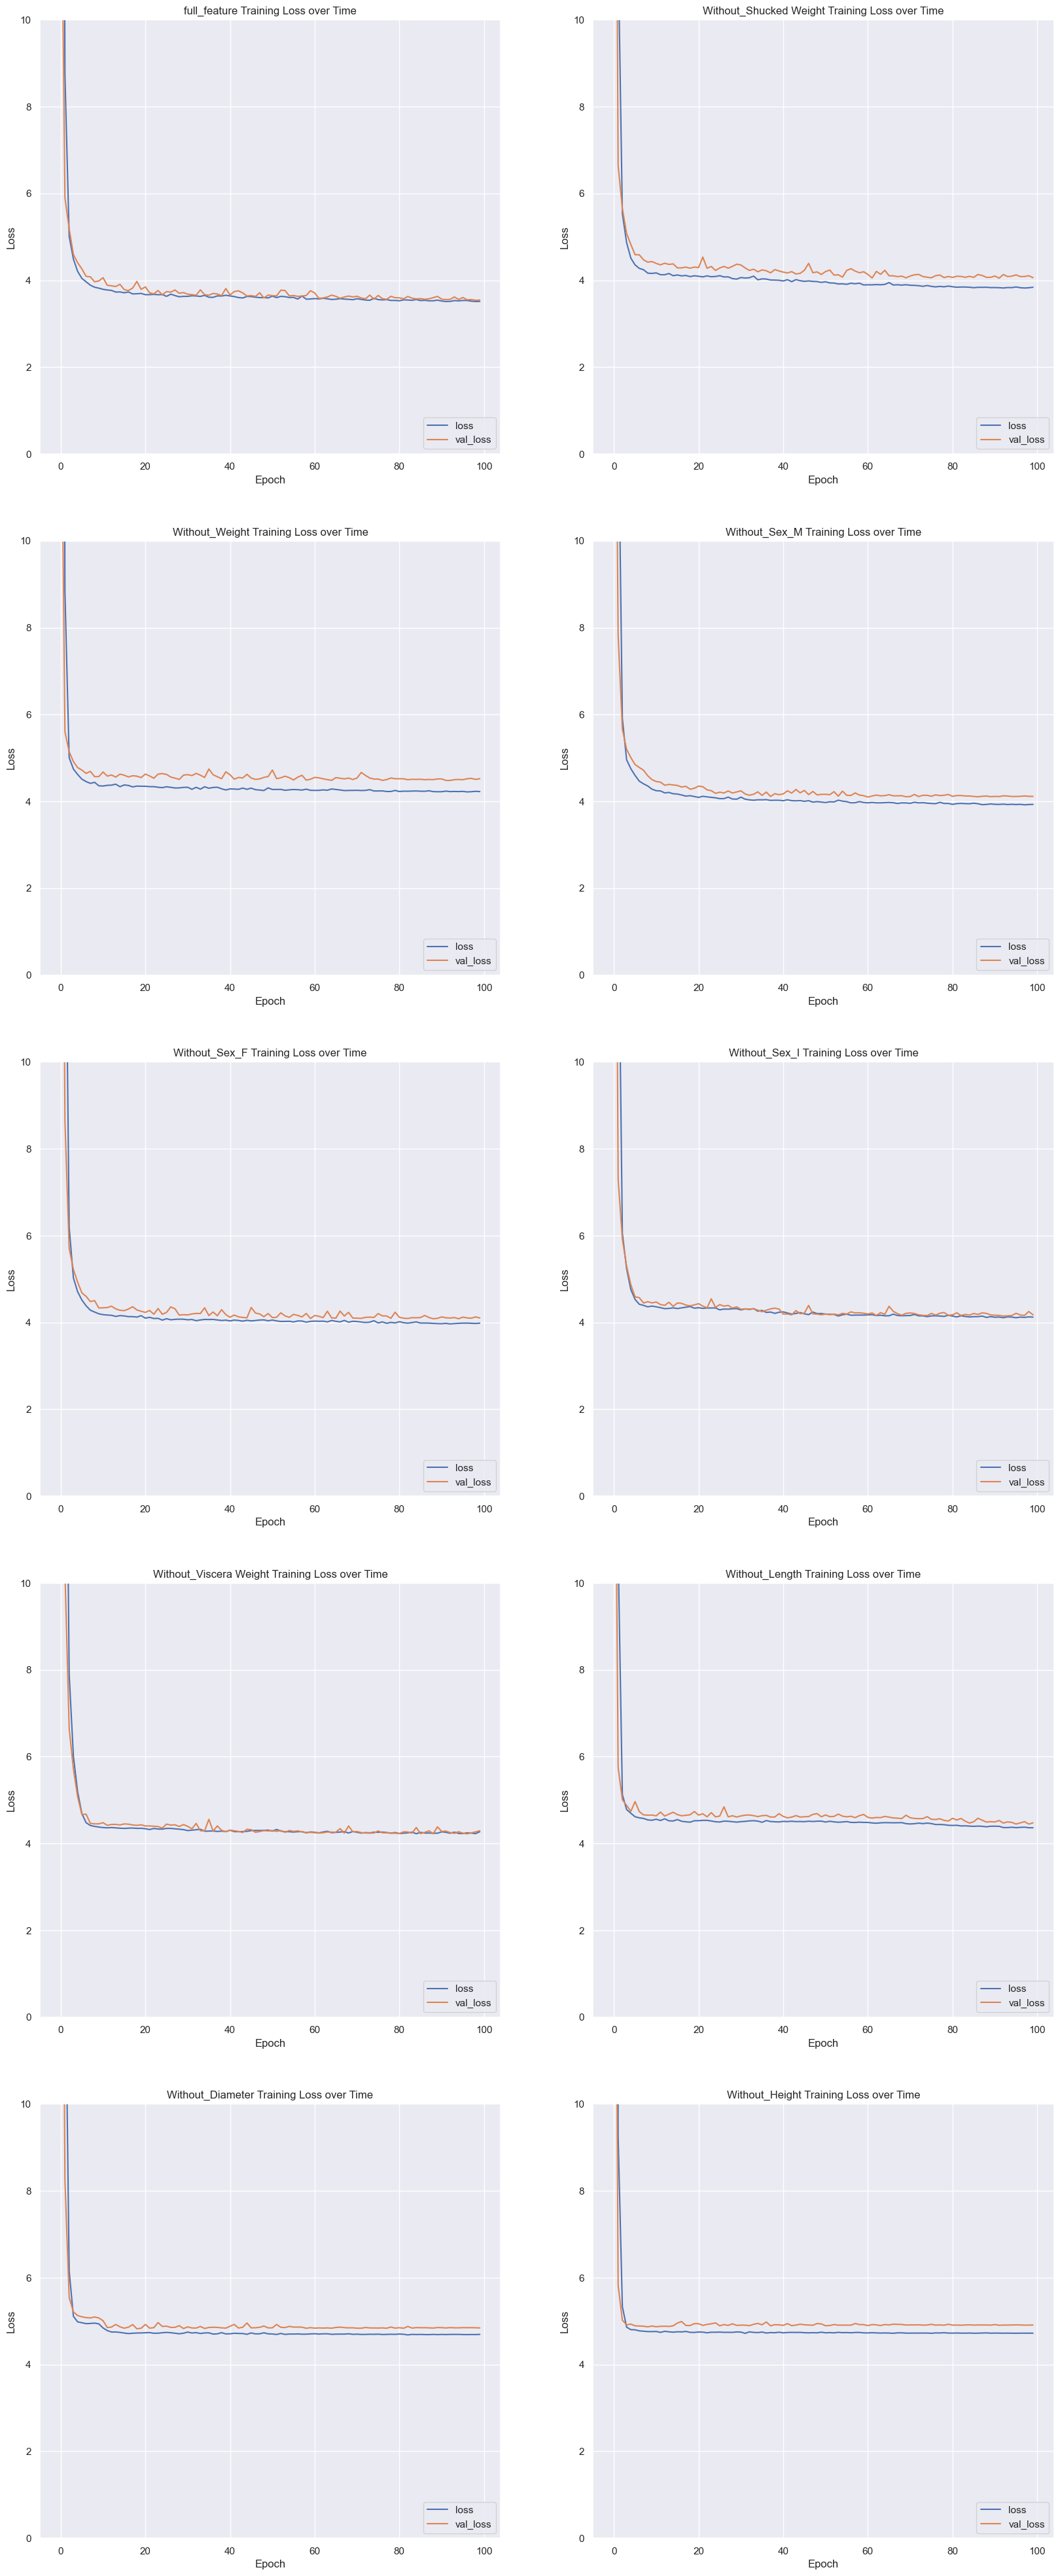

In [15]:
%%time
plot_training_loss_from_dict(rfe_histories)


#### Show the Leaderboard

In [16]:
%%time
rfe_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
full_feature,3.800121,1.434196,0.229652,0.228794
Without_Shucked Weight,4.211046,1.504235,0.055814,0.053739
Without_Weight,4.488319,1.569490,-0.016420,-0.017030
Without_Sex_M,4.369559,1.540570,0.085380,0.085376
Without_Sex_F,4.211710,1.510852,0.024008,0.024007
Without_Sex_I,4.472559,1.577411,0.152374,0.151452
Without_Viscera Weight,4.404398,1.536052,-0.205555,-0.217490
Without_Length,4.489515,1.573346,-0.279293,-0.280908
Without_Diameter,4.754334,1.648322,-0.293010,-0.293171
Without_Height,4.818663,1.661513,-0.325704,-0.326181


#### Bar Chart of Feature Unimportance

CPU times: total: 15.6 ms
Wall time: 15.5 ms


(1.2, 1.8)

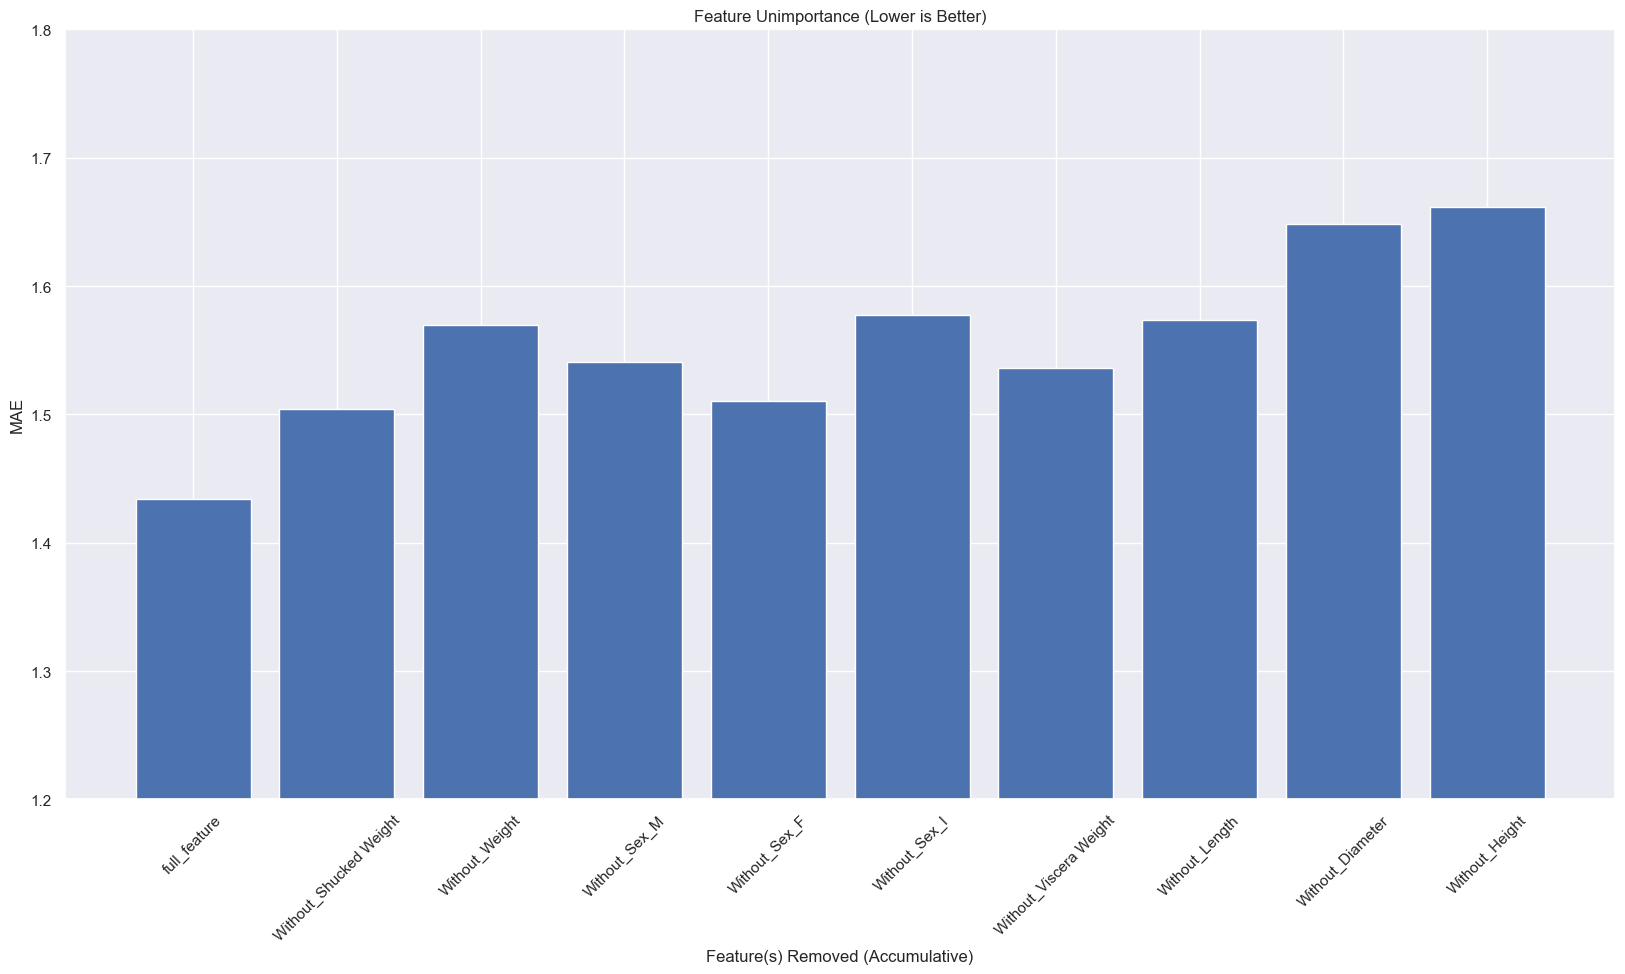

In [17]:
%%time
plt.figure(figsize=(20, 10))
plt.title('Feature Unimportance (Lower is Better)')
plt.bar(rfe_leaderboard_df.index, rfe_leaderboard_df['mean_absolute_error'])
plt.xticks(rotation=45)
plt.xlabel('Feature(s) Removed (Accumulative)')
plt.ylabel('MAE')
plt.ylim(1.2, 1.8)


### Feature Selection Observations

- Removing `Weight` improved the model.
    - This suggests multicollinearity was an issue.
        - We should remove this aggregate feature.
- Removing `Sex_F` improved upon the previous iteration.
    - But it likely was not able to provide insight without its counterparts.
        - We should keep all or none of the one-hot encoded features in this case.  

## Feature Engineering

Feature engineering is a crucial part of the machine learning process. It can make or break a model.

You can:

- Reduce features (with RFE, for example).
- Combine features (avoid collinearity).
- Synthesize new features.

We'll skip combining and synthesizing today, but you can try it on your own.

Feature engineering is an art, not a science. It requires domain knowledge and creativity.

Bias can easily be introduced by feature engineering, so be careful.

However, with careful consideration you can reduce your model's bias.

I don't know a much about selling crabs, so I'll leave this to the curious reader.

### Feature Reduction

We'll remove the aggregate feature, `Weight`, and retrain our selected model in the next section.

#### Remove the Aggregate Weight Feature

This feature likely caused multicollinearity issues. See ya!

In [18]:
%%time
X_train = X_train.drop(['Weight'], axis=1)
X_test = X_test.drop(['Weight'], axis=1)


CPU times: total: 0 ns
Wall time: 0 ns


## Save the Data

So we can pick this back up on the [next step](../3-evaluation/evaluation.ipynb).


In [19]:
%%time
# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


CPU times: total: 0 ns
Wall time: 5.52 ms


## Onwards to Final Evaluation

See the [next section](../3-evaluation/evaluation.ipynb) for the final evaluation.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/3-evaluation/evaluation.ipynb) for model evaluation.
